In [1]:
from statsbombpy import sb

In [2]:
import pandas as pd
import matplotsoccer
import socceraction
pd.options.display.max_columns = None
from socceraction.spadl.statsbomb import StatsBombLoader
from socceraction.spadl import statsbomb
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
statsbombdata = StatsBombLoader(getter="remote")

In [4]:
competitions = statsbombdata.competitions()
selected_competitions = competitions[competitions.competition_name=="La Liga"]

In [5]:


games = list(
    statsbombdata.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
games = pd.concat(games, sort=True).reset_index(drop=True)
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,206,217,2020-07-19 17:00:00,0,5
1,217,215,2020-06-23 22:00:00,1,0
2,209,217,2020-06-27 17:00:00,2,2
3,901,217,2020-07-11 19:30:00,0,1
4,217,205,2020-06-16 22:00:00,2,0
...,...,...,...,...,...
480,217,608,2005-05-01 19:00:00,2,0
481,217,221,2004-12-21 20:00:00,2,1
482,608,217,2004-12-11 20:00:00,1,2
483,217,216,2005-04-17 21:00:00,2,0


In [6]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [],[]
actions = {}
for game in games_verbose:
    # load data
    teams.append(statsbombdata.teams(game.game_id))
    players.append(statsbombdata.players(game.game_id))
    events = statsbombdata.events(game.game_id)
    # convert data
    actions[game.game_id] = statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).reset_index(drop=True)
#player_games = pd.concat(player_games).reset_index(drop=True)

Loading game data: 100%|██████████| 485/485 [15:29<00:00,  1.92s/it]


In [7]:
import socceraction.spadl as spadl
datafolder = "./data-liga"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        
    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()

In [8]:
import socceraction.vaep.features as fs
import socceraction.vaep.labels as lab

In [9]:
datafolder = "./data-liga"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder, "features.h5")
labels_h5 = os.path.join(datafolder, "labels.h5")

In [10]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")


nb of games: 485


In [11]:
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.result,
    fs.result_onehot,
    fs.goalscore,
    fs.startlocation,
    fs.endlocation,
    fs.movement,
    fs.space_delta,
    fs.startpolar,
    fs.endpolar,
    fs.team,
    fs.time,
    fs.time_delta
]

for game in tqdm.tqdm(list(games.itertuples()), desc=f"Generating and storing features in {features_h5}"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes, how="left")
        .merge(results, how="left")
        .merge(bodyparts, how="left")
        .reset_index(drop=True)
    )
    gamestates = fs.gamestates(actions,3)
    gamestates = fs.play_left_to_right(gamestates, game.home_team_id)
    
    X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
    X.to_hdf(features_h5, f"game_{game.game_id}")

Generating and storing features in ./data-liga/features.h5: 100%|██████████| 485/485 [01:23<00:00,  5.83it/s]


In [12]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes, how="left")
        .merge(results, how="left")
        .merge(bodyparts, how="left")
        .reset_index(drop=True)
    )
    
    Y = pd.concat([fn(actions) for fn in yfns], axis=1)
    Y.to_hdf(labels_h5, f"game_{game.game_id}")

Computing and storing labels in ./data-liga/labels.h5: 100%|██████████| 485/485 [00:40<00:00, 11.84it/s]


In [13]:
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)
traingames = games
def getXY(games,Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.read_hdf(features_h5, f"game_{game_id}")
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores","concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.read_hdf(labels_h5, f"game_{game_id}")
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X, Y = getXY(traingames,Xcols)
print("X:", list(X.columns))
print("Y:", list(Y.columns))
X = X.fillna(0)

Selecting label: 100%|██████████| 485/485 [00:03<00:00, 158.19it/s]


X: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'type_pass_a1', 'type_cross_a1', 'type_throw_in_a1', 'type_freekick_crossed_a1', 'type_freekick_short_a1', 'type_corner_crossed_a1', 'type_corner_short_a1', 'type_take_on_a1', 'type_foul_a1', 'type_tackle_a1', 'type_interception_a1', 'type_shot_a1', 'type_shot_penalty_a1', 'type_shot_freekick_a1', 'type_keeper_save_a1', 'type_keeper_claim_a1', 'type_keeper_punch_a1', 'type_keeper_pick_up_a1', 'type_clearance_a1', 'type_bad_touch_a1', 'type_non_action_

In [14]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=2)
    model.fit(X, Y[col])
    models[col] = model

/Users/danielmaloney/.pyenv/versions/3.7.9/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:34:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:34:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:34:39] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:34:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17

[17:35:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:35:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:35:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:35:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:35:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:35:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:35:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

In [15]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

testX, testY = X, Y

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.01122 (0.84204)
  log loss score: 0.05476 (0.76531)
  ROC AUC: 0.83663
### Y: concedes ###
  Brier score: 0.00207 (0.92076)
  log loss score: 0.01246 (0.77975)
  ROC AUC: 0.86512


In [16]:
# get rows with game id per action
features_h5 = os.path.join(datafolder, "features.h5")
labels_h5 = os.path.join(datafolder, "labels.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading game ids"):
    Ai = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 485/485 [00:05<00:00, 88.62it/s] 


In [17]:

with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
    actiontypes = spadlstore["actiontypes"]
    bodyparts = spadlstore["bodyparts"]
    results = spadlstore["results"]
print("nb of games:", len(games))

nb of games: 485


In [20]:
import socceraction.vaep.formula as vaepformula
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        actions
        .merge(actiontypes, how="left")
        .merge(bodyparts, how="left")
        .merge(players, how="left")
        .merge(teams, how="left")
        .merge(results, how="left")
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds,values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 485/485 [00:25<00:00, 18.79it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'bodypart_name',
       'player_name', 'nickname', 'team_name', 'result_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [21]:

A["count"] = 1

# These are useless events that don't measure player skill
       
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
143,5503,Lionel Messi,411.205505,423.404144,-12.198639,64098
889,20131,Xavi,98.981143,98.303539,0.677605,45681
121,5216,Andrés Iniesta,89.811192,87.383141,2.428052,43272
80,4324,Dani Alves,84.726721,86.761127,-2.034406,36034
115,5203,Sergio Busquets,77.469407,74.338861,3.130546,47230
119,5213,Gerard Piqué,53.839506,51.905480,1.934026,39080
145,5506,Javier Mascherano,43.591461,40.631391,2.960070,23257
125,5246,Luis Suárez,43.446571,46.633062,-3.186491,12315
135,5470,Ivan Rakitić,38.648460,37.529669,1.118792,22987
79,4320,Neymar,37.365503,39.644218,-2.278715,13923


In [22]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
#stats[stats.offensive_rating > 0.1]
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
143,5503,Lionel Messi,411.205505,423.404144,-12.198639,64098,40364,0.916869,0.944068,-0.027199
469,6832,Rubén Castro,6.362204,6.416238,-0.054034,537,774,0.739791,0.746074,-0.006283
202,6334,Luis Muriel,1.367531,1.386762,-0.019231,132,181,0.679988,0.689550,-0.009562
1006,24035,Álvaro Vázquez,1.626752,1.762114,-0.135363,121,217,0.674690,0.730831,-0.056141
494,6862,Cédric Bakambu,1.756901,1.811800,-0.054899,146,245,0.645392,0.665559,-0.020167
1361,26105,Iván de la Peña,2.480006,2.627678,-0.147672,281,350,0.637716,0.675689,-0.037973
335,6677,Imanol Agirretxe,1.641176,1.773107,-0.131931,166,243,0.607843,0.656706,-0.048863
196,6297,Maxi Gómez,2.321124,2.373214,-0.052090,177,361,0.578674,0.591660,-0.012986
856,19728,Johnny Heitinga,1.177286,0.994481,0.182806,167,184,0.575847,0.486431,0.089416
122,5217,Iago Aspas,4.400961,4.439173,-0.038212,649,709,0.558655,0.563506,-0.004851


2016-02-14 20:30:00 Barcelona 6-1 Celta Vigo 74' dribble Luis Alberto Suárez Díaz


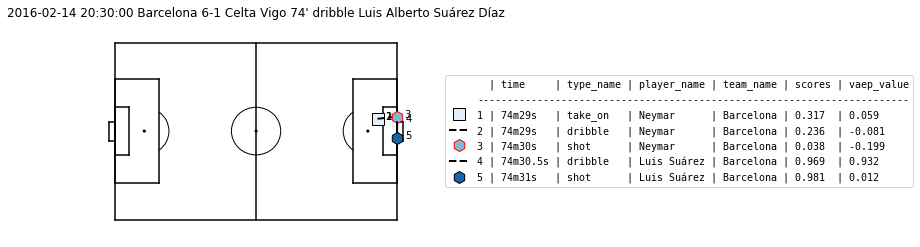

2007-06-17 21:00:00 Gimnàstic Tarragona 1-5 Barcelona 50' dribble Lionel Andrés Messi Cuccittini


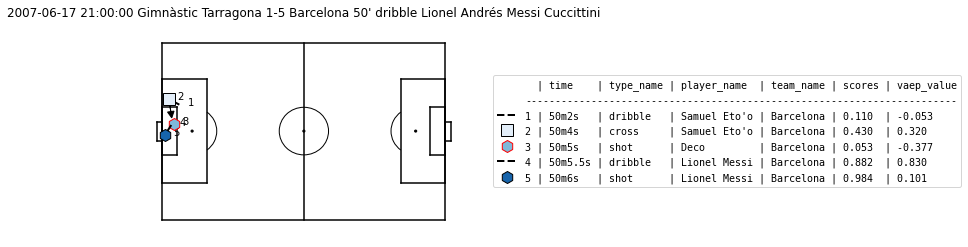

2010-04-17 20:00:00 Espanyol 0-0 Barcelona 8' cross Pedro Eliezer Rodríguez Ledesma


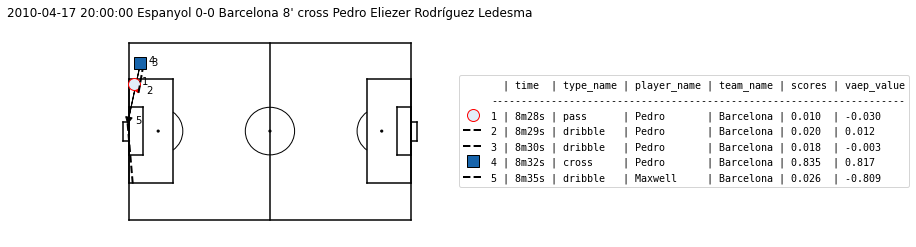

In [27]:
import matplotsoccer
import matplotlib.pyplot as plt
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Barcelona"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,3):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")
    fig,ax = plt.subplots()
    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    ax.set_title(f"{game_info} {minute}' {row.type_name} {row.player_name}")
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                ax=ax,
                zoom=False)
    
    fig.savefig("vaep:" + str(j), bbox_inches="tight")